In [11]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('annotated-excerpts-themes.csv').drop('Unnamed: 10', axis=1)
print(df.columns)
df = df.loc[df['1 = Relevant / 0 = Irrelevant'] == 1]
df = df.loc[df['1 = Reference'] != 1]

def str2set(x):
    if x == x:
        return set(x)
    return x

def clean(x):
    if type(x) != str:
        return x
    
    clean_map = {
        'emotions': 'emotion',
        'choices': 'choice',
        'accountable': 'accountability',
        'debates': 'debate',
        'deliberaton': 'deliberation',
        'discuourse': 'discourse',
        'dicourse': 'discourse',
        'freedom of speech': 'freedom',
        'harsassment': 'harassment',
        'preventing discrimination': 'discrimination',
        'quality-quantity tradeoff': 'quality vs. quantity tradeoff'
    } 
    return [i.strip() if i.strip() not in clean_map else clean_map[i.strip()] for i in x.split(',')]

for col in ['AS Explicit Theme', 'AS Implicit Theme', 'Values',
       'VG Explicit Theme', 'VG Implicit Theme', 'Values.1']:
    df[col] = df[col].apply(clean).apply(str2set)

Index(['Corpus ID', 'Excerpt', '1 = Relevant / 0 = Irrelevant',
       '1 = Reference', 'AS Explicit Theme', 'AS Implicit Theme', 'Values',
       'VG Explicit Theme', 'VG Implicit Theme', 'Values.1'],
      dtype='object')


In [3]:
def sets2set(x):
    x = x.dropna()
    if len(x) > 0:
        return set.union(*x)
    return set()

as_agg_df = df.groupby('Corpus ID').agg(explicit=('AS Explicit Theme', sets2set), \
                                  implicit=('AS Implicit Theme', sets2set), \
                                  values=('Values', sets2set)
                                 )
vg_agg_df = df.groupby('Corpus ID').agg(explicit=('VG Explicit Theme', sets2set), \
                                  implicit=('VG Implicit Theme', sets2set), \
                                  values=('Values.1', sets2set)
                                 )

In [4]:
agg_df = pd.concat([as_agg_df, vg_agg_df]).groupby('Corpus ID').agg({'explicit': lambda x: set.union(*x), \
                                                            'implicit': lambda x: set.union(*x), \
                                                            'values': lambda x: set.union(*x)})
print(sorted(list(set.union(*agg_df['values']))))

In [47]:
# exclude_explicit = [set(['democratizing'])]
# exclude_implicit = [set(['democratizing'])]
exclude_explicit = []
exclude_implicit = []
    
filtered_agg_df = agg_df['values'][(~agg_df['explicit'].isin(exclude_explicit)) & (~agg_df['implicit'].isin(exclude_implicit))]
    
freqs = Counter(filtered_agg_df.apply(list).sum())

In [48]:
topk = freqs.most_common(20)

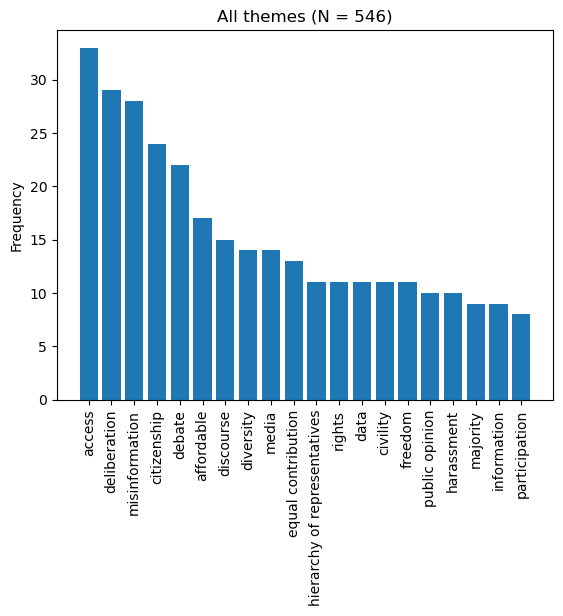

In [50]:
plt.bar(list(zip(*topk))[0], list(zip(*topk))[1])
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('All themes (N = {})'.format(len(filtered_agg_df)))
plt.show()